<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/04_ejercicio_series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Ejercicio de predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

## **Ejercicio:**

El objetivo es **adaptar el notebook** para construir un modelo que prediga las ventas de una tienda. El score será la media del R2 (coeficiente de determinación).

Las columnas del dataset son:

* **Store**: ID de la tienda
* **DayOfWeek**: indica si es lunes, martes, miércoles etc.
* **Date**
* **Sales**: ventas (en euros). Es la variable endógena (a predecir)
* **Customers**: número de clientes que realizan compras
* **Open**: 1 si abre la tienda, 0 si no
* **Promo**: 1 si hay promoción especial en esa tienda, 0 si no
* **SchoolHoliday**: 1 si es festivo escolar, 0 si no
* **Columnas StateHoliday**: indican el tipo de festividad estatal que hay ese día en caso de que la hubiera

In [1]:
COLAB = True

In [2]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='162oyA0BcewOgzcLeIwX_jN9VIu5ZOjhE',
                                        dest_path='./ejercicio_datos_diarios_tienda1.csv')
    gdd.download_file_from_google_drive(file_id='1HwxzlB3Ovl34GgQBgyZoW6gbb0Rs7E2E',
                                        dest_path='./ejercicio_datos_diarios_tienda2.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 8.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5653 sha256=760dcb3cd891f14e94fe0a2141419b17e5746acf0b1ededc731b22b8a3871531
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [3]:
!ls utils

augmentation.py  dtw.py     input_data.py  nemenyi.py
datasets.py	 helper.py  models.py	   prototype_selection.py


In [4]:
import utils.augmentation as aug

## <font color="#CA3532"> **1. Importar librerías**

In [5]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [6]:
!ls

ejercicio_datos_diarios_tienda1.csv  my_utils_series_temporales.py  utils
ejercicio_datos_diarios_tienda2.csv  sample_data


In [7]:
data = pd.read_csv('ejercicio_datos_diarios_tienda1.csv')
#data = pd.read_csv('ejercicio_datos_diarios_tienda2.csv')
data.head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,6,2,2013-01-01,0.0,0.0,0,0,1,0,1,0,0
1,6,3,2013-01-02,6089.0,781.0,1,0,1,1,0,0,0
2,6,4,2013-01-03,5398.0,689.0,1,0,0,1,0,0,0
3,6,5,2013-01-04,6092.0,724.0,1,0,0,1,0,0,0
4,6,6,2013-01-05,3872.0,467.0,1,0,0,1,0,0,0
5,6,7,2013-01-06,0.0,0.0,0,0,0,1,0,0,0
6,6,1,2013-01-07,8591.0,947.0,1,1,0,1,0,0,0
7,6,2,2013-01-08,7099.0,774.0,1,1,0,1,0,0,0
8,6,3,2013-01-09,6749.0,834.0,1,1,0,1,0,0,0
9,6,4,2013-01-10,6282.0,737.0,1,1,0,1,0,0,0


In [8]:
!ls -la

total 104
drwxr-xr-x 1 root root  4096 Dec 18 12:07 .
drwxr-xr-x 1 root root  4096 Dec 18 12:06 ..
drwxr-xr-x 4 root root  4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root 36366 Dec 18 12:07 ejercicio_datos_diarios_tienda1.csv
-rw-r--r-- 1 root root 38421 Dec 18 12:07 ejercicio_datos_diarios_tienda2.csv
-rw-r--r-- 1 root root  4167 Dec 18 12:07 my_utils_series_temporales.py
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
drwxr-xr-x 3 root root  4096 Dec 18 12:07 utils


In [9]:
data.shape

(881, 12)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [10]:
type(data['Date'][0])

str

In [11]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
data['Date']

0     2013-01-01
1     2013-01-02
2     2013-01-03
3     2013-01-04
4     2013-01-05
         ...    
876   2015-05-27
877   2015-05-28
878   2015-05-29
879   2015-05-30
880   2015-05-31
Name: Date, Length: 881, dtype: datetime64[ns]

In [13]:
data["Date"][880].month

5

In [14]:
fechas      = data['Date'].values
customers   = data['Customers'].values
#var modelo
target      = data['Sales'].values #var endógena
mes         = [x.month for x in data['Date']]
festivo1    = data['SchoolHoliday'].values
festivo2    = data['StateHoliday_0'].values
festivo3    = data['StateHoliday_a'].values
festivo4    = data['StateHoliday_b'].values
festivo5    = data['StateHoliday_c'].values
open_       = data['Open'].values
promo       = data['Promo'].values
day_of_week = data['DayOfWeek'].values

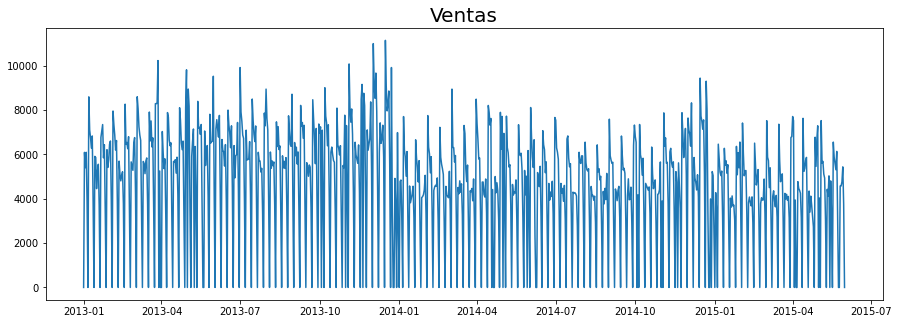

In [15]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Ventas',
          fontsize=20);

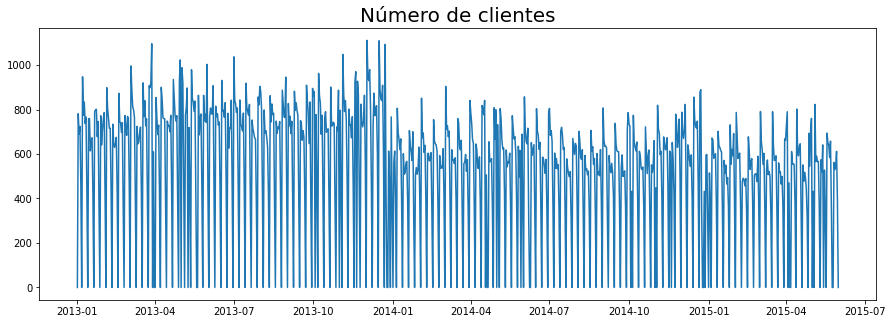

In [16]:
plt.figure(figsize=(15,5))
plt.plot(fechas, customers)
plt.title('Número de clientes', fontsize=20);

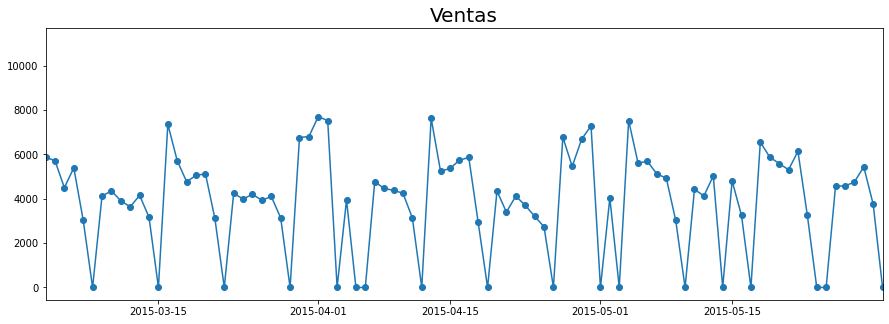

In [17]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Ventas', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

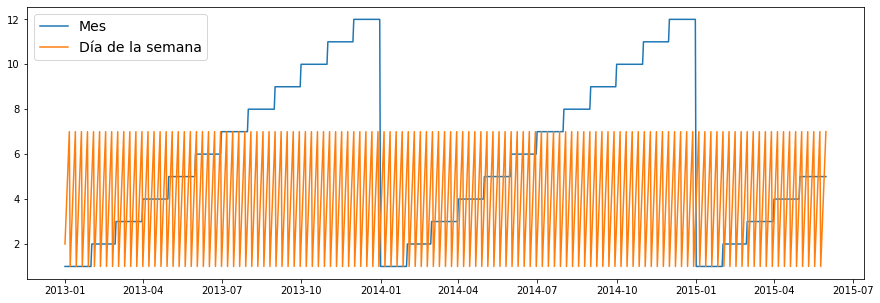

In [18]:
plt.figure(figsize=(15,5))
plt.plot(fechas, mes, label='Mes')
plt.plot(fechas, day_of_week, label='Día de la semana')
plt.legend(fontsize=14);

In [20]:
# Transformación de escala (ajustar el factor en función del problema)
#vemos que la venta
def transform(x):
    return (x-4000)/5000
def inverse_transform(x_escalado):
    return 4000+x_escalado*5000

In [21]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [49]:
# en int2dummy el máximo marcado como entrada es un valor legal
one_hot_mes = int2dummy(mes, 1, 12)
one_hot_day_of_week = int2dummy(day_of_week, 1, 7)

In [50]:
print(one_hot_mes.shape, one_hot_day_of_week.shape)

(881, 12) (881, 7)


In [51]:
target_transf = transform(target)

series = [target_transf, festivo1, festivo2, festivo3, festivo4, festivo5, open_, promo]
se_saben_antes = [False, True, True, True, True, True, True, True]
nombres_series = ["target_transf", "festivo1", "festivo2", "festivo3", "festivo4", "festivo5"]

# Variables calendario sobre las que hemos hecho one-hot encoding
for i in range(one_hot_mes.shape[1]):
    series.append(one_hot_mes[:,i])
    nombres_series.append("mes"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_day_of_week.shape[1]):
    series.append(one_hot_day_of_week[:,i])
    nombres_series.append("day"+str(i+1))
    se_saben_antes.append(True)


In [52]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(27, 881)
(27,)


In [53]:
lookback = 5 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(881, 5, 27) (881,)


In [55]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas)

10 ventanas creadas

X.shape=(10, 5, 27)  Y.shape=(10,) 

 Ventana 0: 


ValueError: ignored